# Implémentez un modèle de scoring

## Exploration et Modelisation

**Import**

In [1]:
# system
import os
import timeit
import pickle

# python
import numpy as np
import pandas as pd

# graph
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn + shap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import make_scorer
import shap

In [2]:
# load JS
shap.initjs()

In [3]:
files = os.listdir('donnee')

Les fichiers disponibles

In [4]:
for name in files:
    nom_fichier = "donnee/"+"/"+name
    data = pd.read_csv(nom_fichier)
    chaine = 'data_' + name[:-4] 
    print("\nNom de Fichier: ",chaine)
    exec(chaine + ' = data')
    print("Taille: ", data.shape)


Nom de Fichier:  data_application_test
Taille:  (48744, 121)

Nom de Fichier:  data_application_train
Taille:  (307511, 122)

Nom de Fichier:  data_bureau
Taille:  (1716428, 17)

Nom de Fichier:  data_bureau_balance
Taille:  (27299925, 3)

Nom de Fichier:  data_credit_card_balance
Taille:  (3840312, 23)

Nom de Fichier:  data_HomeCredit_columns_description
Taille:  (219, 5)

Nom de Fichier:  data_installments_payments
Taille:  (13605401, 8)

Nom de Fichier:  data_POS_CASH_balance
Taille:  (10001358, 8)

Nom de Fichier:  data_previous_application
Taille:  (1670214, 37)


La cible est déséquilibrée (8%/92%)

In [5]:
# TARGET: 8% non nul , 92 % nul
data_application_train.TARGET.mean()

0.08072881945686496

In [6]:
sns.set_theme(style="darkgrid")

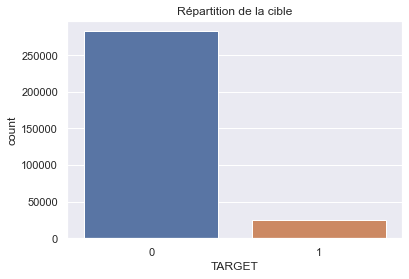

In [7]:
sns.countplot(x='TARGET', data = data_application_train)
plt.title("Répartition de la cible");

Représentation de quelques variables

In [8]:
data_application_train.SK_ID_CURR.describe()

count    307511.000000
mean     278180.518577
std      102790.175348
min      100002.000000
25%      189145.500000
50%      278202.000000
75%      367142.500000
max      456255.000000
Name: SK_ID_CURR, dtype: float64

In [9]:
def fig_hist(data,var):
    plt.figure(figsize=(15,4))
    plt.suptitle(var)
    plt.subplot(131)
    data[var].hist()

    plt.subplot(133)
    data[var].plot(kind='box',showfliers=False)

    plt.subplot(132)
    data[var].plot(kind='box');

In [10]:
data_application_train['ANNUITY_INCOME_PERC'] = data_application_train['AMT_ANNUITY'] / data_application_train['AMT_INCOME_TOTAL']
data_application_train['PAYMENT_RATE'] = data_application_train['AMT_ANNUITY'] / data_application_train['AMT_CREDIT']

In [11]:
list_var = [
    'PAYMENT_RATE',
    'AMT_ANNUITY',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'ANNUITY_INCOME_PERC',
    'TARGET'
]

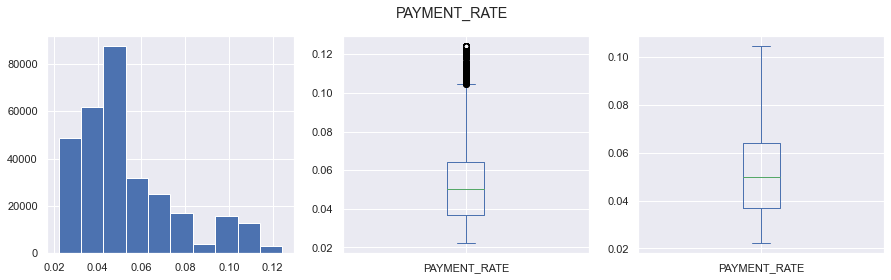

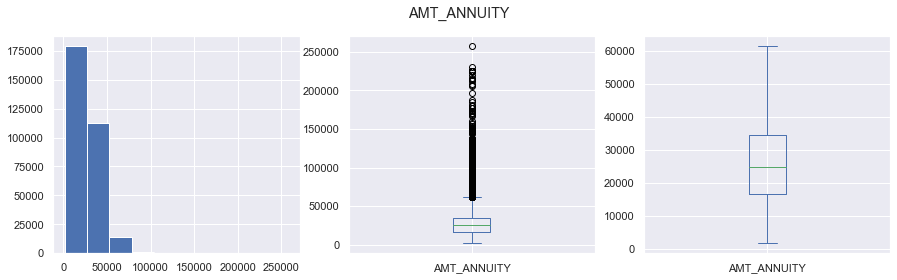

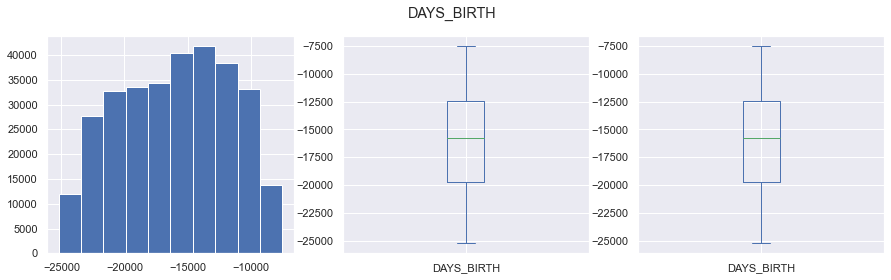

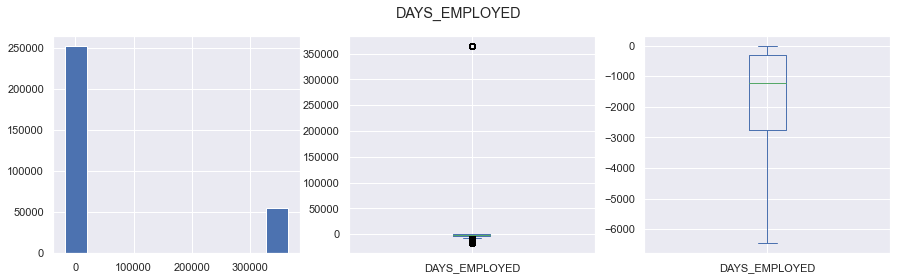

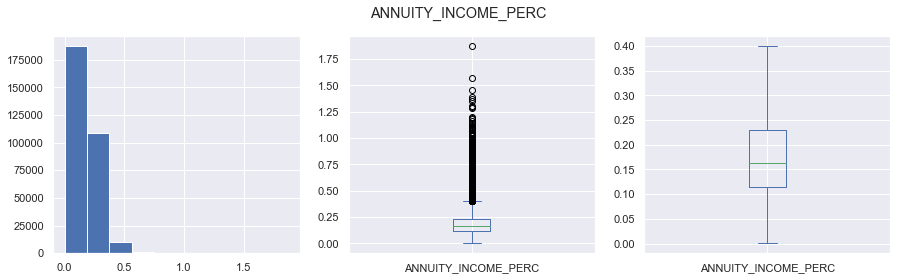

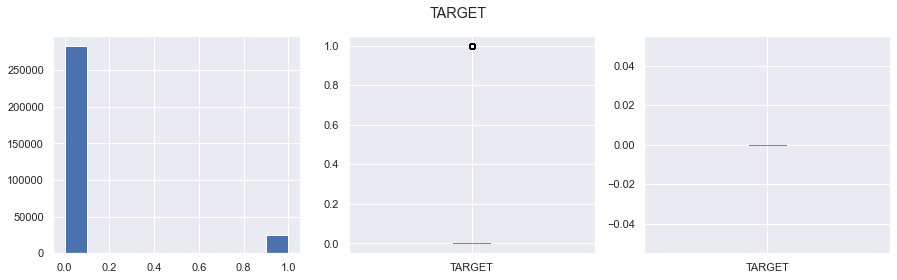

In [12]:
for var in list_var:
    fig_hist(data_application_train,var)

In [13]:
data_application_train.isna().mean()[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]

EXT_SOURCE_1    0.563811
EXT_SOURCE_2    0.002146
EXT_SOURCE_3    0.198253
dtype: float64

In [14]:
data_application_train.isna().mean()[list_var]

PAYMENT_RATE           0.000039
AMT_ANNUITY            0.000039
DAYS_BIRTH             0.000000
DAYS_EMPLOYED          0.000000
ANNUITY_INCOME_PERC    0.000039
TARGET                 0.000000
dtype: float64

**Chargement des jeux de données**

In [15]:
app_train = pd.read_csv('donnee_pretraitre\donnee_train_pretraitrement.csv')
app_test = pd.read_csv('donnee_pretraitre\donnee_test_pretraitrement.csv')

**Création des jeux train/test**

In [16]:
## Entree X
X = app_train.drop(columns=['TARGET'])

## Sortie y
y = app_train['TARGET']

In [17]:
## Separation en jeu train et test
from sklearn import model_selection

X_train, X_test, y_train, y_test = \
model_selection.train_test_split(X, y,
                                 test_size=0.2, # 20% des données dans le jeu de test
                                 stratify=y)

## Prétraitrement

In [18]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV

In [19]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

Definition des fonctions

In [20]:
# Calcul d´un score basé sur les faux positifs, negatifs etc.

def mycosts(y, y_pred):

    # recuperation de la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel() 

    # calcul 
    value = fn+tn
    # value = 10*fn+fp
    # value = 1*fn+fp
    
    # value
    return  value

myscorer = make_scorer(mycosts)

In [21]:
# Tuning of pipeline parameters , RandomizedSearchCV

scores = {'roc': 'roc_auc',
          'score_fnfp':myscorer,
          'recall':'recall'}

def model_randomsearch(X_train, y_train, steps, params, nb_iter):
    
    '''  tuning of pipeline parameters '''
    
    cv = KFold(5, shuffle=True, random_state=42)

    pipeline = imbpipeline(steps=steps)
    
#     randomscv = GridSearchCV(
#         pipeline, 
#         param_grid=params,
#         cv=cv,
#         scoring = scores,
#         refit='score_fnfp',
#         n_jobs=-1)

    randomscv = RandomizedSearchCV(
        pipeline, 
        param_distributions=params, 
        n_iter=nb_iter,
        cv=cv,
        scoring = scores,
        refit='score_fnfp',
        random_state=42, n_jobs=-1)
    
    randomscv.fit(X_train, y_train)
    
    return randomscv

In [22]:
# Pipeline et Rééquilibrage des données

import imblearn
from imblearn.under_sampling  import RandomUnderSampler
from imblearn.over_sampling import SMOTE

def pipeline_steps(classifier):
    ''' function to create steps of a pipeline '''
    
    imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()

    # class are imbalanced
    # oversampling of the minority class
    over = SMOTE(random_state=42)
    
    # undersampling of the majority class
    under = RandomUnderSampler(random_state=42)

    # steps for the pipeline
    steps = [['imputer', imputer], ['scaler', scaler],
             ['over', over], ['under', under],
             ['classifier', classifier]]
    return steps

**Modele naif**

In [23]:
from sklearn import dummy
from sklearn import metrics
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline

# create pipeline for classifier to test
steps_dc = pipeline_steps(DummyClassifier(random_state=42))

# parameters to test
params_dc = {'over__sampling_strategy': [0.1, 0.2, 0.3],
             'under__sampling_strategy': [0.4, 0.5, 0.6]}

# Number of iteration
n_iter = 1

In [24]:
random_dc = model_randomsearch( X_train, 
                                    y_train, 
                                    steps_dc, 
                                    params_dc, 
                                    n_iter )

In [25]:
random_dc.best_params_

{'under__sampling_strategy': 0.5, 'over__sampling_strategy': 0.3}

In [26]:
result = {}

In [27]:
result['Dummy'] = [random_dc.best_score_, random_dc.cv_results_['mean_test_roc'][random_dc.best_index_]]
result = pd.DataFrame(result,index=['score_fnfp','roc'])
result

,Dummy
score_fnfp,49201.6
roc,0.5


**Modele Random Forest**

In [28]:
from sklearn.ensemble import RandomForestClassifier

# create pipeline for classifier to test
steps = pipeline_steps(RandomForestClassifier())

# parameters to test
params = {'over__sampling_strategy': [0.1, 0.2, 0.3],
          'under__sampling_strategy': [0.4, 0.5, 0.6]}

# Number of iteration
n_iter = 1

## temps de départ
start_time = timeit.default_timer()

random_mdl_forest = model_randomsearch( X_train, 
                                    y_train, 
                                    steps, 
                                    params, 
                                    n_iter )

## temps final
elapsed = timeit.default_timer() - start_time
print(elapsed)    

199.4496669


In [29]:
result['RandomForest'] = [random_mdl_forest.best_score_, random_mdl_forest.cv_results_['mean_test_roc'][random_mdl_forest.best_index_]]
round(pd.DataFrame(result,index=['score_fnfp','roc']),2)

,Dummy,RandomForest
score_fnfp,49201.6,49011.20
roc,0.5,0.71


**Modele LightGBM**

In [30]:
import lightgbm as lgb

# create pipeline for classifier to test
steps = pipeline_steps(lgb.LGBMClassifier())

# parameters to test
params = {'over__sampling_strategy': [0.1, 0.2, 0.3],
          'under__sampling_strategy': [0.4, 0.5, 0.6]}

# Number of iteration
n_iter = 1

## temps de départ
start_time = timeit.default_timer()

random_lgb = model_randomsearch( X_train, 
                                    y_train, 
                                    steps, 
                                    params, 
                                    n_iter )

## temps final
elapsed = timeit.default_timer() - start_time
print(elapsed)    

70.3807582


**Synthese des calculs**

In [31]:
result['Light gb'] = [random_lgb.best_score_, random_lgb.cv_results_['mean_test_roc'][random_lgb.best_index_]]
result = pd.DataFrame(result,index=['score_fnfp','roc'])
round(result,2)

,Dummy,RandomForest,Light gb
score_fnfp,49201.6,49011.20,48569.40
roc,0.5,0.71,0.75


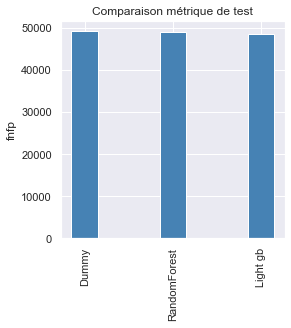

In [32]:
## graphique
## plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(4, 4))
var_mae=result.iloc[0,:]
plt.bar(range(len(var_mae)),var_mae,color="steelblue",width=0.3)
plt.xticks(range(len((var_mae))),var_mae.index,rotation=90);
plt.title('Comparaison métrique de test')
plt.ylabel('fnfp')
plt.rcParams.update({'font.size': 12})

In [33]:
round(result,2)

,Dummy,RandomForest,Light gb
score_fnfp,49201.6,49011.20,48569.40
roc,0.5,0.71,0.75


**On effectue les calculs avec LightGBM**

In [34]:
import lightgbm as lgb

# create pipeline for classifier to test
steps = pipeline_steps(lgb.LGBMClassifier(boosting_type='goss'))

# parameters to test
params = {
    'over__sampling_strategy': [0.1],
    'under__sampling_strategy': [0.4],
    'classifier__n_estimators' : [100,200],
    'classifier__learning_rate' : [0.05],
    'classifier__num_leaves':[50,60,70,80],
    'classifier__max_depth':[7,10,12]
          }

# Number of iteration
n_iter = 5

## temps de départ
start_time = timeit.default_timer()

random_mdl = model_randomsearch( X_train, 
                                    y_train, 
                                    steps, 
                                    params, 
                                    n_iter )

## temps final
elapsed = timeit.default_timer() - start_time
print(elapsed)    

One or more of the test scores are non-finite: [       nan        nan 0.74654782 0.74510792 0.74575308]
One or more of the test scores are non-finite: [    nan     nan 45105.2 44650.8 44662.4]
One or more of the test scores are non-finite: [       nan        nan 0.28092153 0.30174915 0.30134966]


258.84767539999996


In [35]:
random_mdl.best_params_

{'under__sampling_strategy': 0.4,
 'over__sampling_strategy': 0.1,
 'classifier__num_leaves': 50,
 'classifier__n_estimators': 100,
 'classifier__max_depth': 7,
 'classifier__learning_rate': 0.05}

In [36]:
# parametres opti kaggle

# LIGHTGBM_PARAMS = {
#     'boosting_type': 'goss',
#     'n_estimators': 10000,
#     'learning_rate': 0.005134,
#     'num_leaves': 54,
#     'max_depth': 10,
#     'subsample_for_bin': 240000,
#     'reg_alpha': 0.436193,
#     'reg_lambda': 0.479169,
#     'colsample_bytree': 0.508716,
#     'min_split_gain': 0.024766,
#     'subsample': 1,
#     'is_unbalance': False,
#     'silent':-1,
#     'verbose':-1
# }

**Simulation sur valeur de test**

In [37]:
## simulation sur valeur de test
modele_global = random_mdl.best_estimator_
start_time = timeit.default_timer()
y_pred = modele_global.predict(X_test)
elapsed = timeit.default_timer() - start_time
print(elapsed)    

1.130075500000089


In [38]:
# defaut client index
np.where(y_pred[:1000]==1)

(array([ 15,  17,  37,  52,  54,  63,  94,  98, 104, 138, 152, 161, 163,
        171, 180, 182, 201, 236, 246, 247, 254, 259, 263, 264, 280, 293,
        311, 332, 334, 390, 394, 399, 416, 450, 500, 502, 521, 536, 548,
        552, 570, 598, 610, 629, 637, 638, 656, 664, 665, 670, 683, 686,
        688, 693, 695, 706, 725, 726, 772, 782, 787, 789, 790, 861, 872,
        898, 909, 922, 944, 954, 964, 967, 986], dtype=int64),)

In [39]:
X_test.shape

(61503, 241)

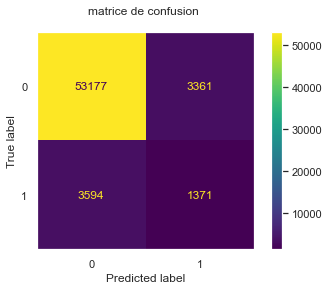

In [40]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(None)
plt.title('matrice de confusion \n');


In [41]:
cm.ravel()

array([53177,  3361,  3594,  1371], dtype=int64)

In [42]:
tn, fp, fn, tp = cm.ravel()

In [43]:
# precision tp / (tp + fp)
round(100*(tp / (tp + fp)))

29

In [44]:
# recall tp / (tp + fn)
round(100*(tp / (tp + fn)))

28

## Interpretation

**Feature importance**

In [45]:
importances = modele_global.named_steps['classifier'].feature_importances_

In [46]:
features_name = app_test.columns

In [47]:
df = pd.DataFrame(importances,features_name,columns=['importance'])

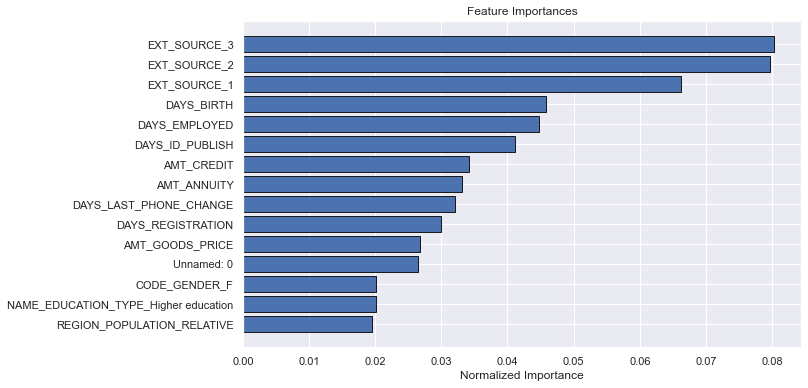

In [48]:
# Sort features according to importance
df = df.sort_values('importance', ascending = False).reset_index()

# Normalize the feature importances to add up to one
df['importance_normalized'] = df['importance'] / df['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()

# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(df.index[:15]))), 
        df['importance_normalized'].head(15), 
        align = 'center', edgecolor = 'k')

# Set the yticks and labels
ax.set_yticks(list(reversed(list(df.index[:15]))))
ax.set_yticklabels(df['index'].head(15))

# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()


In [49]:
df['index'].head(15)

0                             EXT_SOURCE_3
1                             EXT_SOURCE_2
2                             EXT_SOURCE_1
3                               DAYS_BIRTH
4                            DAYS_EMPLOYED
5                          DAYS_ID_PUBLISH
6                               AMT_CREDIT
7                              AMT_ANNUITY
8                   DAYS_LAST_PHONE_CHANGE
9                        DAYS_REGISTRATION
10                         AMT_GOODS_PRICE
11                              Unnamed: 0
12                           CODE_GENDER_F
13    NAME_EDUCATION_TYPE_Higher education
14              REGION_POPULATION_RELATIVE
Name: index, dtype: object

**SHAP**

In [50]:
mdl_pipeline = modele_global.steps

In [51]:
mdl_pipeline

[('imputer', SimpleImputer(strategy='median')),
 ('scaler', StandardScaler()),
 ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
 ('under', RandomUnderSampler(random_state=42, sampling_strategy=0.4)),
 ['classifier',
  LGBMClassifier(boosting_type='goss', learning_rate=0.05, max_depth=7,
                 num_leaves=50)]]

Preparation des variables d´entrees pour shap

In [52]:
X,y = imbpipeline(mdl_pipeline[:4]).fit_resample(X_train,y_train)

In [53]:
X.shape

(79149, 241)

In [54]:
y.shape

(79149,)

In [55]:
X = pd.DataFrame(X, columns=app_test.columns)

In [56]:
X

,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,1.022557,1.020021,-0.324769,1.391304,0.664011,-0.576839,-0.044073,-0.310617,1.571701,-0.238212,...,-0.176657,-0.087448,-0.07633,-0.07314,-0.523210,-0.516473,-0.132175,-1.037338,-0.087825,-0.468273
1,-1.520423,-1.520359,-0.324769,-0.718750,0.664011,-0.576839,0.166555,0.804910,-0.000060,1.042635,...,-0.176657,-0.087448,-0.07633,-0.07314,1.911279,-0.516473,-0.132175,0.964006,-0.087825,-0.468273
2,-1.203086,-1.204310,-0.324769,-0.718750,0.664011,-0.576839,-0.219596,1.714380,0.738149,1.591570,...,-0.176657,-0.087448,-0.07633,-0.07314,-0.523210,1.936211,-0.132175,0.964006,-0.087825,-0.468273
3,-0.931557,-0.931644,-0.324769,-0.718750,-1.506000,0.808377,-0.202043,-0.855181,-0.687026,-0.848139,...,-0.176657,-0.087448,-0.07633,-0.07314,-0.523210,-0.516473,-0.132175,-1.037338,-0.087825,-0.468273
4,1.174862,1.171699,-0.324769,-0.718750,0.664011,-0.576839,0.043689,-0.192487,1.013929,-0.238212,...,-0.176657,-0.087448,-0.07633,-0.07314,1.911279,-0.516473,-0.132175,0.964006,-0.087825,-0.468273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79144,-1.495824,-1.496315,-0.324769,1.391304,0.664011,0.353623,0.190400,-0.361144,0.140092,-0.341152,...,-0.176657,-0.087448,-0.07633,-0.07314,-0.523210,-0.516473,-0.132175,-1.037338,-0.087825,-0.468273
79145,1.340550,1.340634,-0.324769,-0.718750,-1.506000,-0.576839,-0.103600,-0.513237,-0.254979,-0.628292,...,-0.176657,-0.087448,-0.07633,-0.07314,-0.523210,-0.516473,-0.132175,-1.037338,-0.087825,2.135505
79146,0.953369,0.952197,-0.324769,-0.718750,-0.258113,0.011794,-0.163858,-0.557206,-0.023113,-0.574558,...,-0.176657,-0.087448,-0.07633,-0.07314,1.911279,-0.516473,-0.132175,0.964006,-0.087825,-0.468273
79147,0.420856,0.421839,2.375126,-0.718750,0.664011,0.521889,0.149601,-0.946428,-1.091052,-0.867130,...,-0.176657,-0.087448,-0.07633,-0.07314,1.911279,-0.516473,-0.132175,0.964006,-0.087825,-0.468273


In [57]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79149 entries, 0 to 79148
Columns: 241 entries, Unnamed: 0 to DAYS_EMPLOYED_ANOM
dtypes: float64(241)
memory usage: 145.5 MB


In [58]:
X = X.astype('float')

In [59]:
X = X.reset_index()

In [60]:
X.shape

(79149, 242)

In [61]:
X.drop(X.columns[[0,1]],axis=1,inplace=True)

In [62]:
X.shape

(79149, 240)

In [63]:
y.shape

(79149,)

SHAP: les contributions de chaque variables, localement et globalement.

In [65]:
mdl = modele_global.named_steps['classifier']

In [66]:
explainer = shap.Explainer(mdl,X)

In [67]:
shap_values = explainer(X)

100%|===================| 78788/79149 [02:48<00:00]        

In [68]:
X

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,1.020021,-0.324769,1.391304,0.664011,-0.576839,-0.044073,-0.310617,1.571701,-0.238212,-1.025449,...,-0.176657,-0.087448,-0.07633,-0.07314,-0.523210,-0.516473,-0.132175,-1.037338,-0.087825,-0.468273
1,-1.520359,-0.324769,-0.718750,0.664011,-0.576839,0.166555,0.804910,-0.000060,1.042635,-0.981909,...,-0.176657,-0.087448,-0.07633,-0.07314,1.911279,-0.516473,-0.132175,0.964006,-0.087825,-0.468273
2,-1.204310,-0.324769,-0.718750,0.664011,-0.576839,-0.219596,1.714380,0.738149,1.591570,-1.140039,...,-0.176657,-0.087448,-0.07633,-0.07314,-0.523210,1.936211,-0.132175,0.964006,-0.087825,-0.468273
3,-0.931644,-0.324769,-0.718750,-1.506000,0.808377,-0.202043,-0.855181,-0.687026,-0.848139,-0.045260,...,-0.176657,-0.087448,-0.07633,-0.07314,-0.523210,-0.516473,-0.132175,-1.037338,-0.087825,-0.468273
4,1.171699,-0.324769,-0.718750,0.664011,-0.576839,0.043689,-0.192487,1.013929,-0.238212,-0.149597,...,-0.176657,-0.087448,-0.07633,-0.07314,1.911279,-0.516473,-0.132175,0.964006,-0.087825,-0.468273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79144,-1.496315,-0.324769,1.391304,0.664011,0.353623,0.190400,-0.361144,0.140092,-0.341152,0.442378,...,-0.176657,-0.087448,-0.07633,-0.07314,-0.523210,-0.516473,-0.132175,-1.037338,-0.087825,-0.468273
79145,1.340634,-0.324769,-0.718750,-1.506000,-0.576839,-0.103600,-0.513237,-0.254979,-0.628292,-0.577230,...,-0.176657,-0.087448,-0.07633,-0.07314,-0.523210,-0.516473,-0.132175,-1.037338,-0.087825,2.135505
79146,0.952197,-0.324769,-0.718750,-0.258113,0.011794,-0.163858,-0.557206,-0.023113,-0.574558,-0.400851,...,-0.176657,-0.087448,-0.07633,-0.07314,1.911279,-0.516473,-0.132175,0.964006,-0.087825,-0.468273
79147,0.421839,2.375126,-0.718750,0.664011,0.521889,0.149601,-0.946428,-1.091052,-0.867130,-0.098007,...,-0.176657,-0.087448,-0.07633,-0.07314,1.911279,-0.516473,-0.132175,0.964006,-0.087825,-0.468273


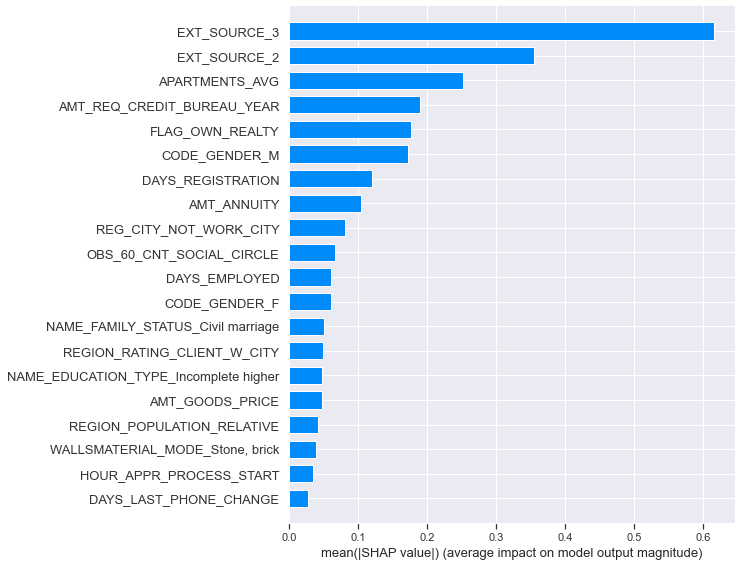

In [69]:
shap.summary_plot(shap_values,X, plot_type="bar")

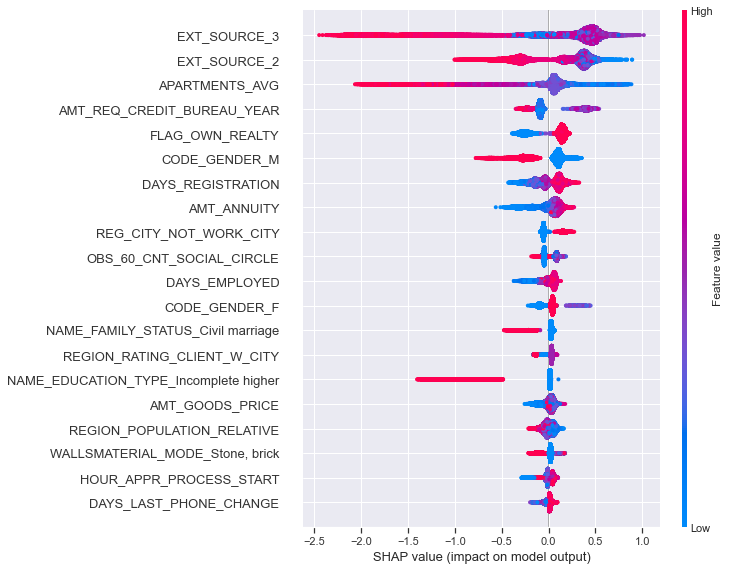

In [70]:
shap.summary_plot(shap_values,X)

In [71]:
# visualize the first prediction's explaination with default colors
shap.force_plot(shap_values[2])

### Sauvegarde du modele

In [72]:
import pickle

In [73]:
mdl_forest = random_mdl_forest.best_estimator_
pickl = {'model': mdl_forest}
pickle.dump( pickl, open( 'model_file_forest' + ".pkl", "wb" ) )

In [74]:
random_mdl_forest.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ['classifier', RandomForestClassifier()]])

In [75]:
pickl = {'model': modele_global}
pickle.dump( pickl, open( 'model_file' + ".pkl", "wb" ) )

In [76]:
pickl

{'model': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                 ('scaler', StandardScaler()),
                 ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                 ('under',
                  RandomUnderSampler(random_state=42, sampling_strategy=0.4)),
                 ['classifier',
                  LGBMClassifier(boosting_type='goss', learning_rate=0.05,
                                 max_depth=7, num_leaves=50)]])}